### Install libraries

In [1]:
!pip install -qU wandb
!pip install -q segmentation-models-pytorch 
!pip install -q torchsummary
!pip install -q rasterio
!pip install -q colorama

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.13.2 which is incompatible.


In [2]:
%load_ext autoreload
%autoreload 2

## IMPORT LIBRARIES

In [3]:
# Misc
import copy
import time
import timm
import joblib
import random
import os, shutil
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from IPython import display as ipd
from collections import defaultdict
from joblib import Parallel, delayed
from matplotlib.patches import Rectangle 

# Sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold, KFold

# Pytorch
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.cuda import amp
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
import segmentation_models_pytorch as smp 

# Image Processing Libraries
import cv2
import rasterio 
import skimage.io

from PIL import Image

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Import and Login to Weight&Biases 
import wandb

try:
    wandb.login(key='29b54518076f707810c9bac855d80a73e7e057a5') # API Key
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
import gc
gc.collect()

1414

## CONFIGURATIONS

In [23]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baselinev1'
    comment       = 'UNet-Resnet152-512x512-aug2-split2'
    model_name    = 'UNet'
    encoder       = 'resnet152'
    train_bs      = 5
    valid_bs      = train_bs
    img_size      = [512, 512]
    size          = 256
    epochs        = 20
    lr            = 1e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(10000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-4
    n_fold        = 5
    num_classes   = 2
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## REPRODUCIBILITY

In [24]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


## IMAGE PRE-PROCESSING

#### Load Data

In [25]:
# Image and Mask Path
IMAGE_PATH = '../input/seagrass/train_images/training_images/'
MASK_PATH = '../input/seagrass/train_label/training_label/'

In [26]:
n_classes = 2

def create_df():
    img_name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            img_name.append(filename.split('.')[0])

    mask_name = []
    for dirname, _, filenames in os.walk(MASK_PATH):
        for filename in filenames:
            mask_name.append(filename.split('.')[0])
            
    img_name = sorted(img_name)
    mask_name = sorted(mask_name)

    return pd.DataFrame({'img_id': img_name, 'mask_id': mask_name}, index = np.arange(0, len(img_name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  961


In [27]:
df # list of drone images

,img_id,mask_id
0,1B102321_01_01,1B102321_01_01
1,1B102321_01_02,1B102321_01_02
2,1B102321_01_03,1B102321_01_03
3,1B102321_01_04,1B102321_01_04
4,1B102321_01_05,1B102321_01_05
...,...,...
956,1B102321_31_27,1B102321_31_27
957,1B102321_31_28,1B102321_31_28
958,1B102321_31_29,1B102321_31_29
959,1B102321_31_30,1B102321_31_30


#### Split data to Train, Test, and Validation

In [28]:
# Split data
X_trainval, X_test = train_test_split(df['img_id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  734
Val Size     :  130
Test Size    :  97


Image Size (512, 512, 3)
Mask Size (512, 512)


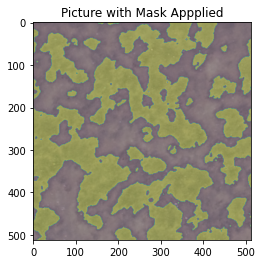

In [29]:
img = skimage.io.imread(IMAGE_PATH + df['img_id'][500] + '.tif', plugin='tifffile')
mask = skimage.io.imread(MASK_PATH + df['mask_id'][500] + '.tif', plugin='tifffile')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.30)
plt.title('Picture with Mask Appplied')
plt.show()

In [30]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.mean = [0.4855, 0.5464, 0.4754]
        self.std = [0.1446, 0.1593, 0.1308]
        self.transform = transform
        self.patches = patch
        self.count = 0
   
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        img = skimage.io.imread(self.img_path + self.X[idx] + '.tif', plugin='tifffile')
        img = np.array(img, dtype='uint8')
        img = cv2.resize(img, dsize=(CFG.size,CFG.size), interpolation=cv2.INTER_AREA)
        
        mask = skimage.io.imread(self.mask_path + self.X[idx] + '.tif', plugin='tifffile')
        mask = np.array(mask, dtype='uint8')
        mask = cv2.resize(mask, dsize=(CFG.size,CFG.size), interpolation=cv2.INTER_AREA)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor()])
        mean, std = t(img).mean([1,2]), t(img).std([1,2])

        transform = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = transform(img)
        
        #t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        #img = t(img)
      
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, CFG.size, CFG.size).unfold(2, CFG.size, CFG.size) 
        img_patches  = img_patches.contiguous().view(3,-1, CFG.size, CFG.size) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, CFG.size, CFG.size).unfold(1, CFG.size, CFG.size)
        mask_patches = mask_patches.contiguous().view(-1, CFG.size, CFG.size)
        
        return img_patches, mask_patches

#### Data augmentation

In [31]:
# Data Augmentation
t_train = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), 
                     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
                     A.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25, p=0.75),
                     A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, p=0.5), 
                     A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), 
                   A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, p=0.5)])

#datasets

train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, t_train, patch=False)
train_loader = DataLoader(train_set, batch_size=CFG.train_bs, shuffle=True, num_workers=0, pin_memory=True)

val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, t_val, patch=False)
val_loader = DataLoader(val_set, batch_size=CFG.valid_bs, shuffle=True, num_workers=0, pin_memory=True)  

In [32]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([5, 3, 256, 256]), torch.Size([5, 256, 256]))

## MODEL

### UNet

In [33]:
def build_model():
    model = smp.Unet(
        encoder_name = CFG.encoder,
        encoder_weights = 'imagenet',
        encoder_depth = 5,
        classes = CFG.num_classes,
        activation = 'sigmoid',
        decoder_channels = [256, 128, 64, 32, 16]
    )

    model.to(CFG.device)
    return model

def load_model(path):

    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

### DeepLabV3

In [ ]:
def build_model():
    model = smp.DeepLabV3(
        encoder_name = CFG.encoder,
        encoder_weights = 'imagenet',
        encoder_depth = 5,
        classes = CFG.num_classes,
        activation = 'sigmoid',
        decoder_channels = 256
    )

    model.to(CFG.device)
    return model

def load_model(path):

    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

#### Loss Function

In [34]:
# Loss Function
CrossEntropyLoss = nn.CrossEntropyLoss()
BCELoss = nn.BCELoss() 

# Metrics
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def dice_coef(pred_mask, mask, smooth = 1):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        
        mask = torch.flatten(mask).to(torch.float32)
        pred_mask = torch.flatten(pred_mask).to(torch.float32)
        
        intersection = torch.sum(mask * pred_mask)
        score = (2. * intersection + smooth) / (torch.sum(mask) + torch.sum(pred_mask) + smooth) 
        
    return score.cpu().numpy()

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
                
    return np.nanmean(iou_per_class)

#### Train One Epoch Function

In [35]:
def train_one_epoch(model, optimizer, scheduler, criterion, dataloader, device, epoch, patch=False):

    model.train()

    scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0.0

    train_scores = []

    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc = 'Train')
    for steps, (images, masks) in pbar:

        images = images.to(device)
        masks = masks.to(device)

        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion(y_pred, masks)
        
        loss.backward()
        
        # Zero the parameter gradients
        optimizer.step()  
        optimizer.zero_grad()
        
        scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        
        train_iou = mIoU(y_pred, masks)
        train_acc = pixel_accuracy(y_pred, masks)
        train_dce = dice_coef(y_pred, masks)
        train_scores.append([train_iou, train_acc, train_dce]) 

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss = f'{epoch_loss:0.4f}',
                        lr = f'{current_lr:0.5f}',
                        gpu_mem = f'{mem:0.2f} GB')
    
    train_scores = np.mean(train_scores, axis = 0)
      
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, train_scores

#### Validate One Epoch Function

In [36]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, criterion, device, epoch):

    model.eval()

    dataset_size = 0
    running_loss = 0.0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc = 'Validation')
    for steps, (images, masks) in pbar:

        images = images.to(device)
        masks = masks.to(device)

        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion(y_pred, masks)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        val_iou = mIoU(y_pred, masks)
        val_acc = pixel_accuracy(y_pred, masks)
        val_dce = dice_coef(y_pred, masks)
        val_scores.append([val_iou, val_acc, val_dce])

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss = f'{epoch_loss:0.4f}',
                          lr = f'{current_lr:0.5f}',
                          gpu_memory = f'{mem:0.2f} GB')
      
    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, val_scores

#### Run Training Function

In [37]:
def run_training(model, optimizer, scheduler, criterion, device, epochs):
    
    # log gradients to wandb
    wandb.watch(model, criterion, log='all', log_freq=100)

    if torch.cuda.is_available():
        print ("cuda: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_iou = -np.inf
    best_dce = -np.inf
    best_acc = -np.inf
    best_epoch = -1
    history = defaultdict(list)

    for epoch in range(1, epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{epochs}', end = '')
        
        train_loss, train_scores = train_one_epoch(model, optimizer, scheduler, criterion, 
                                     dataloader = train_loader,
                                     device = CFG.device, epoch = epoch)

        val_loss, val_scores = valid_one_epoch(model, val_loader, criterion, 
                                               device = CFG.device, epoch = epoch)
        train_iou, train_acc, train_dce = train_scores
        val_iou, val_acc, val_dce = val_scores

        history['Train Loss'].append(train_loss)
        history['Train IoU'].append(train_iou)
        history['Train Pixel Accuracy'].append(train_acc)
        history['Train Dice'].append(train_dce)
        history['Valid Loss'].append(val_loss)
        history['Valid IoU'].append(val_iou)
        history['Valid Pixel Accuracy'].append(val_acc)
        history['Valid Dice'].append(val_dce)
      
        # Log the metrics
        wandb.log({"Train Loss": train_loss,
                   "Train Iou": train_iou,
                   "Train Pixel Accuracy": train_acc,
                   "Train Dice": train_dce,
                   "Valid Loss": val_loss,
                   "Valid IoU": val_iou,
                   "Valid Pixel Accuracy": val_acc,
                   "Valid Dice": val_dce,
                   "LR":scheduler.get_last_lr()[0]})

        print(f'Train IoU: {train_iou:0.4f} | Train Pixel Accuracy: {train_acc:0.4f} | Train Dice: {train_dce:0.4f}')
        print(f'Valid IoU: {val_iou:0.4f} | Valid Pixel Accuracy: {val_acc:0.4f} | Valid Dice: {val_dce:0.4f}')
  

        # Deep copy model 
        if val_iou >= best_iou:
            print(f"{c_}Valid IoU Improved ({best_iou:0.4f} ---> {val_iou:0.4f})")
            print(f"{c_}Valid Dice Coef Improved ({best_dce:0.4f} ---> {val_dce:0.4f})")
            print(f"{c_}Valid Pixel Accuracy Improved ({best_acc:0.4f} ---> {val_acc:0.4f})")
            best_iou = val_iou
            best_acc = val_acc
            best_epoch = epoch
            run.summary["Best IoU"] = best_iou
            run.summary["Best Dice Coef"] = best_dce
            run.summary["Best Accuracy"] = best_acc
            run.summary["Best Epoch"] = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{best_epoch:02d}.bin"
            torch.save(model.state_dict(), PATH)
            wandb.save(PATH)
            print(f"Model Saved{sr_}")
        
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{epoch:02d}.bin"
        torch.save(model.state_dict(), PATH)

        print() ; print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print('Best Score: {:.4f}'.format(best_iou))

    model.load_state_dict(best_model_wts)

    return model, history

#### Scheduler Function

In [38]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [39]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

## TRAINING

In [40]:
run = wandb.init(project='bluecares-seagrass-dl', 
                config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                anonymous=anonymous,
                name=f"model-{CFG.model_name}|encoder-{CFG.encoder}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}",
                group=CFG.comment,
)

model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

#optimizer = torch.optim.AdamW(model.parameters(), lr = CFG.lr, weight_decay=CFG.wd)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, CFG.lr, epochs=CFG.epochs,
#                                            steps_per_epoch=len(train_loader))

model, history = run_training(model, optimizer, scheduler, CrossEntropyLoss, 
                  device=CFG.device,
                  epochs=CFG.epochs)
# run.finish()
display(ipd.IFrame(run.url, width=1000, height=720)) 

wandb: Currently logged in as: cgcandido. Use `wandb login --relogin` to force relogin


cuda: Tesla P100-PCIE-16GB

Epoch 1/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.4944 | Train Pixel Accuracy: 0.6692 | Train Dice: 0.5709
Valid IoU: 0.6264 | Valid Pixel Accuracy: 0.7817 | Valid Dice: 0.7389
Valid IoU Improved (-inf ---> 0.6264)
Valid Dice Coef Improved (-inf ---> 0.7389)
Valid Pixel Accuracy Improved (-inf ---> 0.7817)
Model Saved


Epoch 2/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.5407 | Train Pixel Accuracy: 0.7093 | Train Dice: 0.6292
Valid IoU: 0.6206 | Valid Pixel Accuracy: 0.7685 | Valid Dice: 0.7705


Epoch 3/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.5647 | Train Pixel Accuracy: 0.7245 | Train Dice: 0.6650
Valid IoU: 0.5872 | Valid Pixel Accuracy: 0.7547 | Valid Dice: 0.7035


Epoch 4/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6150 | Train Pixel Accuracy: 0.7660 | Train Dice: 0.7149
Valid IoU: 0.7776 | Valid Pixel Accuracy: 0.8801 | Valid Dice: 0.8623
Valid IoU Improved (0.6264 ---> 0.7776)
Valid Dice Coef Improved (-inf ---> 0.8623)
Valid Pixel Accuracy Improved (0.7817 ---> 0.8801)
Model Saved


Epoch 5/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6335 | Train Pixel Accuracy: 0.7788 | Train Dice: 0.7339
Valid IoU: 0.3519 | Valid Pixel Accuracy: 0.5281 | Valid Dice: 0.5517


Epoch 6/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6195 | Train Pixel Accuracy: 0.7700 | Train Dice: 0.7197
Valid IoU: 0.7395 | Valid Pixel Accuracy: 0.8575 | Valid Dice: 0.8414


Epoch 7/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6146 | Train Pixel Accuracy: 0.7668 | Train Dice: 0.7180
Valid IoU: 0.7413 | Valid Pixel Accuracy: 0.8596 | Valid Dice: 0.8405


Epoch 8/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6616 | Train Pixel Accuracy: 0.8004 | Train Dice: 0.7592
Valid IoU: 0.7048 | Valid Pixel Accuracy: 0.8373 | Valid Dice: 0.8251


Epoch 9/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6448 | Train Pixel Accuracy: 0.7877 | Train Dice: 0.7406
Valid IoU: 0.7304 | Valid Pixel Accuracy: 0.8552 | Valid Dice: 0.8318


Epoch 10/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6622 | Train Pixel Accuracy: 0.8013 | Train Dice: 0.7648
Valid IoU: 0.7791 | Valid Pixel Accuracy: 0.8825 | Valid Dice: 0.8731
Valid IoU Improved (0.7776 ---> 0.7791)
Valid Dice Coef Improved (-inf ---> 0.8731)
Valid Pixel Accuracy Improved (0.8801 ---> 0.8825)
Model Saved


Epoch 11/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6762 | Train Pixel Accuracy: 0.8105 | Train Dice: 0.7722
Valid IoU: 0.7107 | Valid Pixel Accuracy: 0.8373 | Valid Dice: 0.8351


Epoch 12/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6728 | Train Pixel Accuracy: 0.8094 | Train Dice: 0.7718
Valid IoU: 0.7149 | Valid Pixel Accuracy: 0.8446 | Valid Dice: 0.8244


Epoch 13/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6866 | Train Pixel Accuracy: 0.8200 | Train Dice: 0.7810
Valid IoU: 0.8157 | Valid Pixel Accuracy: 0.9031 | Valid Dice: 0.8985
Valid IoU Improved (0.7791 ---> 0.8157)
Valid Dice Coef Improved (-inf ---> 0.8985)
Valid Pixel Accuracy Improved (0.8825 ---> 0.9031)
Model Saved


Epoch 14/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6847 | Train Pixel Accuracy: 0.8182 | Train Dice: 0.7810
Valid IoU: 0.7791 | Valid Pixel Accuracy: 0.8837 | Valid Dice: 0.8713


Epoch 15/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6893 | Train Pixel Accuracy: 0.8209 | Train Dice: 0.7826
Valid IoU: 0.7802 | Valid Pixel Accuracy: 0.8804 | Valid Dice: 0.8716


Epoch 16/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6942 | Train Pixel Accuracy: 0.8245 | Train Dice: 0.7854
Valid IoU: 0.8147 | Valid Pixel Accuracy: 0.9026 | Valid Dice: 0.8947


Epoch 17/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.7077 | Train Pixel Accuracy: 0.8338 | Train Dice: 0.8019
Valid IoU: 0.7838 | Valid Pixel Accuracy: 0.8826 | Valid Dice: 0.8772


Epoch 18/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6845 | Train Pixel Accuracy: 0.8182 | Train Dice: 0.7776
Valid IoU: 0.7883 | Valid Pixel Accuracy: 0.8897 | Valid Dice: 0.8819


Epoch 19/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.7022 | Train Pixel Accuracy: 0.8313 | Train Dice: 0.7961
Valid IoU: 0.7833 | Valid Pixel Accuracy: 0.8828 | Valid Dice: 0.8732


Epoch 20/20

Train:   0%|          | 0/147 [00:00<?, ?it/s]

Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Train IoU: 0.6957 | Train Pixel Accuracy: 0.8256 | Train Dice: 0.7913
Valid IoU: 0.7841 | Valid Pixel Accuracy: 0.8863 | Valid Dice: 0.8774


Training complete in 0h 30m 9s
Best Score: 0.8157


## LOAD VALIDATION DATASET

In [41]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):

        img = skimage.io.imread(self.img_path + self.X[idx] + '.tif', plugin='tifffile')
        img = np.array(img, dtype='uint8')
        img = cv2.resize(img, dsize=(CFG.size,CFG.size), interpolation=cv2.INTER_AREA)
        
        mask = skimage.io.imread(self.mask_path + self.X[idx] + '.tif', plugin='tifffile')
        mask = np.array(mask, dtype='uint8')
        mask = cv2.resize(mask, dsize=(CFG.size,CFG.size), interpolation=cv2.INTER_AREA)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(CFG.size, CFG.size, interpolation=cv2.INTER_AREA)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## PREDICTION 

#### IoU

In [42]:
def predict_image_mask_miou(model, image, mask, mean=[0.4855, 0.5464, 0.4754], std=[0.1446, 0.1593, 0.1308]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
        
    return masked, score

#### Pixel Accuracy

In [43]:
def predict_image_mask_pixel(model, image, mask, mean=[0.4855, 0.5464, 0.4754], std=[0.1446, 0.1593, 0.1308]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
        
    return masked, acc

#### Dice Coefficient

In [44]:
def predict_image_mask_dice(model, image, mask, mean=[0.4855, 0.5464, 0.4754], std=[0.1446, 0.1593, 0.1308]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = dice_coef(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
        
    return masked, acc

Prediction:   0%|          | 0/97 [00:00<?, ?it/s]

TypeError: unhashable type: 'Image'

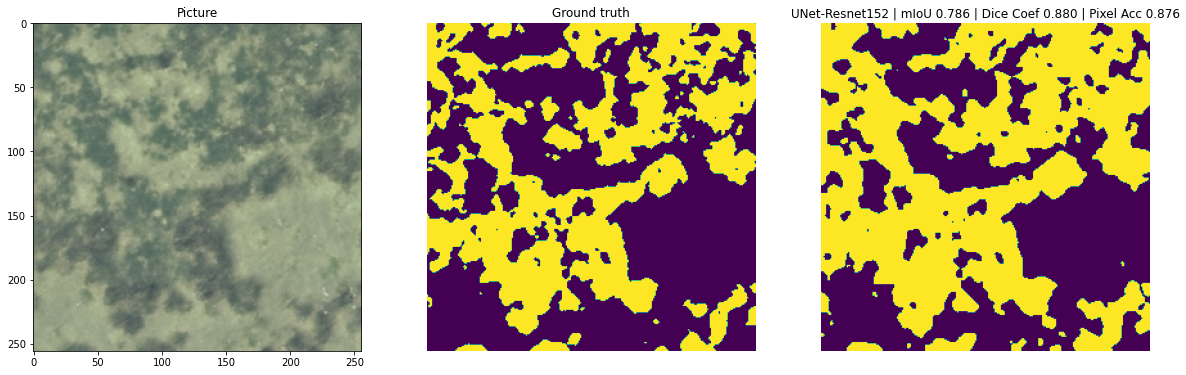

In [54]:
import PIL
data = []
scores = []

table = wandb.Table(columns=['IMAGE', 'IoU', 'DICE_COEF', 'PIXEL_ACCURACY'])

pbar = tqdm(enumerate(test_set), total = len(test_set), desc = 'Prediction')
for steps, (image2, mask2) in pbar:
    #image2, mask2 = image
    #image2 = image2.to(device)
    #mask2 = mask2.to(device)
    
    pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)
    pred_mask3, score3 = predict_image_mask_pixel(model, image2, mask2)
    pred_mask4, score4 = predict_image_mask_dice(model, image2, mask2)
        
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
    ax1.imshow(image2)
    ax1.set_title('Picture');
    
    ax2.imshow(mask2)
    ax2.set_title('Ground truth')
    ax2.set_axis_off()
    
    ax3.imshow(pred_mask2)
    ax3.set_title('UNet-Resnet152 | mIoU {:.3f} | Dice Coef {:.3f} | Pixel Acc {:.3f}'.format(score2, score3, score4))
    ax3.set_axis_off()
    
    scores.append([score2, score3, score4])
    
    table.add_data({wandb.Image(image2), score2, score3, score4})
    
    run.log({"Seagrass Predictions": table})

In [ ]:
run.finish()